# CSCA 5642: Introduction to Deep Learning week3

Author: Nobuo Takizawa  
GitHub Repository: https://github.com/nobuyo/intro-to-dl

## Description of the problem

* kaggle competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection
* A task to find metastatic cancer in a given microscopic image.
* Binary classification of whether cancer is detected or not.
* ROC AUC is used for performance evaluation.


In [1]:
# standard lib
import random

# numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# image processing
from PIL import Image
import cv2

# utils
from tqdm import tqdm

# sklearn
from sklearn.model_selection import train_test_split

# tf
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers, models, metrics

# hyperparameter tuning
import keras_tuner as kt

# save objects
import pickle

First of all, let us load the train labels.

In [2]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# About the Data

This section describes the structure of the data.

First, we look at the df that we just read from the csv, which has one column for id and one for label, where id corresponds to the name of the image file.
The `label` is, as the name implies, label data. 1 indicates that cancer is included.

In [16]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The dataset has 220k+ samples.

In [5]:
df.shape

(220025, 2)

The image size is 96px x 96px, and the channel size is 3(RGB).

In [20]:
image = Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{df['id'][0]}.tif")
h, w, c = np.array(image).shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

width:   96
height:  96
channel: 3


# EDA

First, check to see if there are any duplicates in the data, but it appears there are not.

In [46]:
df.duplicated().sum()

0

Let's pick up the images and look at them by simply filtering by label and displaying the first ten images.
All images have a purplish tint, possibly due to the staining solution. There is also variation in the size and density of the tissue reflected in the images.


Visually, I cannot perceive much difference.

label = 0


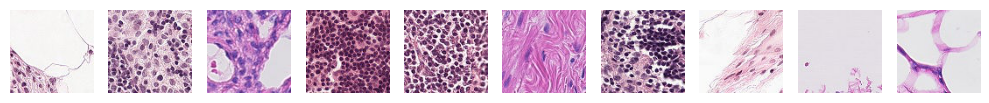

label = 1


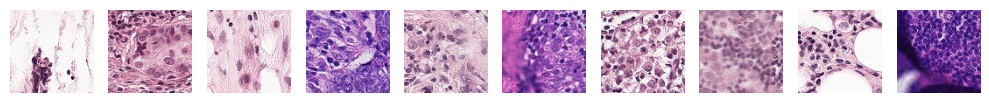

In [40]:
def show_images(label):
    print(f'label = {label}')
    image_paths = [f"/kaggle/input/histopathologic-cancer-detection/train/{id}.tif" for id in df[df['label'] == label]['id'][:10].values]
    images = [Image.open(path) for path in image_paths]
    
    fig, axes = plt.subplots(1, len(images), figsize=(10, 10))
    
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_images(label=0)
show_images(label=1)

Examine counts by label.
There is a slight bias, but not a fatal imbalance because of the overall volume.

In [41]:
df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

From here, I will attempt to plot the image values numerically.
First, sample 5,000 for each of the label values 0 and 1, and 10,000 from the total. This is because the entire data set is too large to handle.

In [71]:
def sample_image_ids(n=10000, label=None):
    base = df
    if label is not None:
        base = df[df['label'] == label]
    sample_size = 10000
    sample_ids = random.sample(list(base['id'].values), sample_size)
    return sample_ids

In [78]:
sample_ids = sample_image_ids()
sample_ids_0 = sample_image_ids(n=5000, label=0)
sample_ids_1 = sample_image_ids(n=5000, label=1)

Take the average of the pixel values and plot them. The graph shows 10,000 samples from all data and 5,000 samples for each of the labels 0 and 1.

Since the pixel values are averages, that is, the brighter the entire image is, the larger the value will be.

The one with label=0 has two peaks, while the one with label=1 has a shape similar to a normal distribution in which the brighter peak does not exist
In other words, it is possible that there is a factor that makes the image darker for some reason in images where cancer is observed.

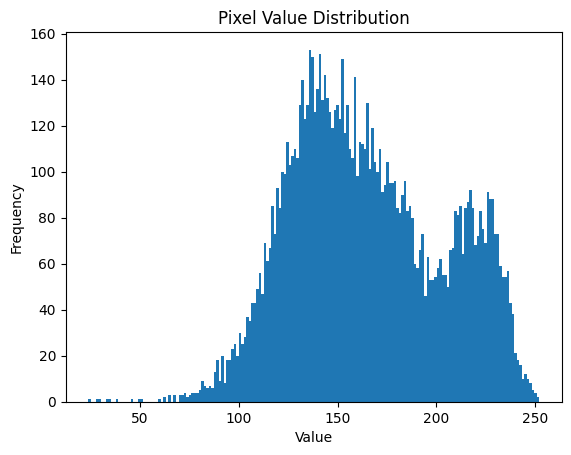

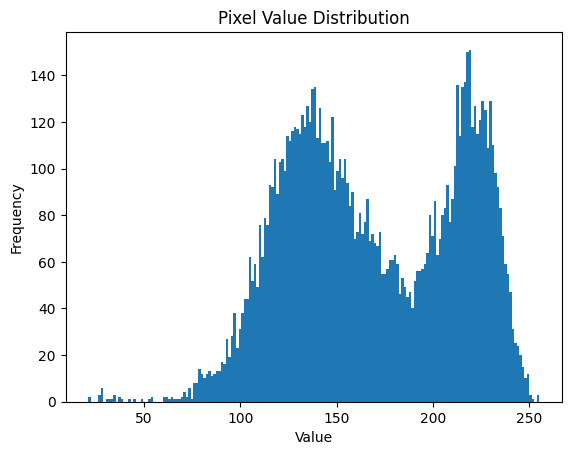

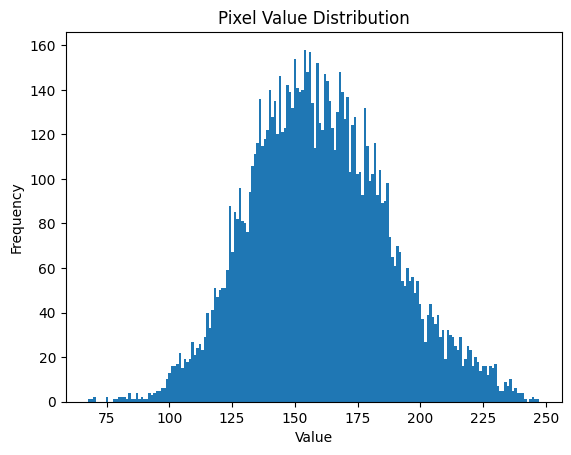

In [75]:
def pixel_value_distribution(ids, title):
    pixel_means = []
    
    for id in tqdm(ids):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{id}.tif"
        img = cv2.imread(img_path)
        if img is not None:
            pixel_means.append(np.mean(img))
    
    plt.hist(pixel_means, bins=50)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

pixel_value_distribution(sample_ids, "Pixel Value Distribution")
pixel_value_distribution(sample_ids_0, "Pixel Value Distribution (label=0)")
pixel_value_distribution(sample_ids_1, "Pixel Value Distribution (label=1)")

Next, I plot the std of pixel values. For the same sample as before, we plotted the distribution of std values over the entire image.

- label=0 has a peak of 60, and the area from 20 to 40 is also distorted.
- label=1 has a balanced shape with the peak around 50.
- In other words, samples with cancer tend to have less contrast on average than those without cancer, and most of the std values are within a certain range.
- However, it seems difficult to get an intuitive inference.

100%|██████████| 10000/10000 [00:19<00:00, 516.00it/s]


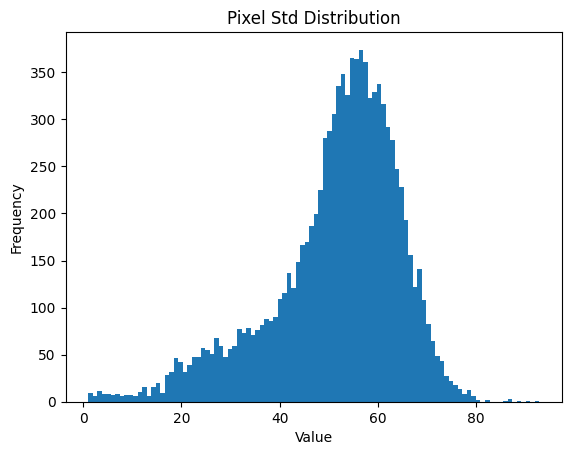

100%|██████████| 10000/10000 [00:20<00:00, 494.62it/s]


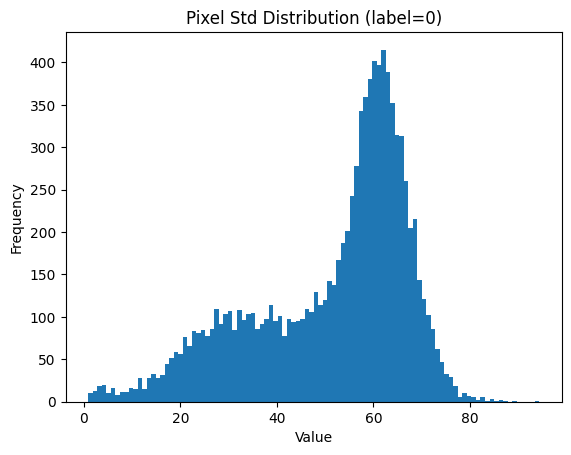

100%|██████████| 10000/10000 [00:21<00:00, 458.15it/s]


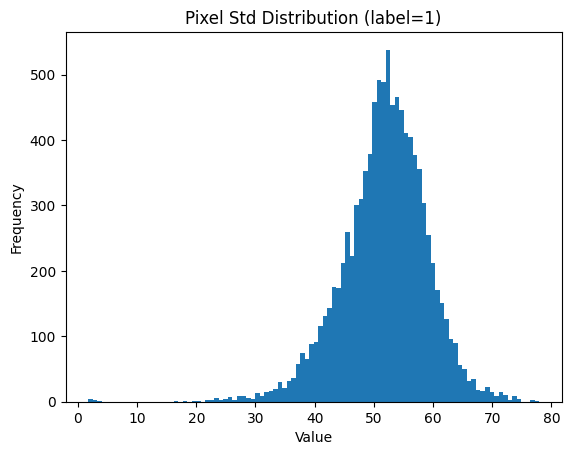

In [106]:
def pixel_std_distribution(ids, title):
    pixel_means = []
    for id in tqdm(ids):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{id}.tif"
        img = cv2.imread(img_path)
        if img is not None:
            pixel_means.append(np.std(img))
    
    plt.hist(pixel_means, bins=100)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

pixel_std_distribution(sample_ids, "Pixel Std Distribution")
pixel_std_distribution(sample_ids_0, "Pixel Std Distribution (label=0)")
pixel_std_distribution(sample_ids_1, "Pixel Std Distribution (label=1)")

Next we will look at the plot in HSV color space.
The reason we do not look at RGB is that microscopic images of stained tissue are almost always the same color. There is no need to analyze each RGB channel unless, for example, only cancer is stained green and the rest are stained red.

The first step is hue.
The plotted values were calculated by converting the RGB image to HSV and taking the average of the hue channels.

The data extracted as a sample is the same as the previous one.

What I notice in the graphs
- Graphs with label=1 have a small frequency around 150
- Microscopic images are stained, and the degree of staining is considered to change depending on what tissue is shown in the image.
- The images that show cancer have a common color after staining, which may be reflected in the difference between the label=0 plot and the label1 plot.

100%|██████████| 10000/10000 [00:14<00:00, 678.66it/s]


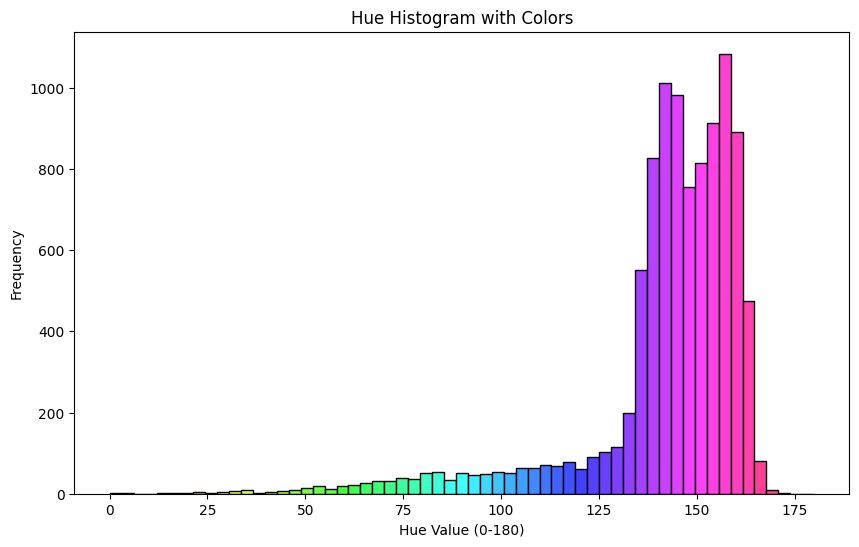

100%|██████████| 10000/10000 [00:15<00:00, 663.26it/s]


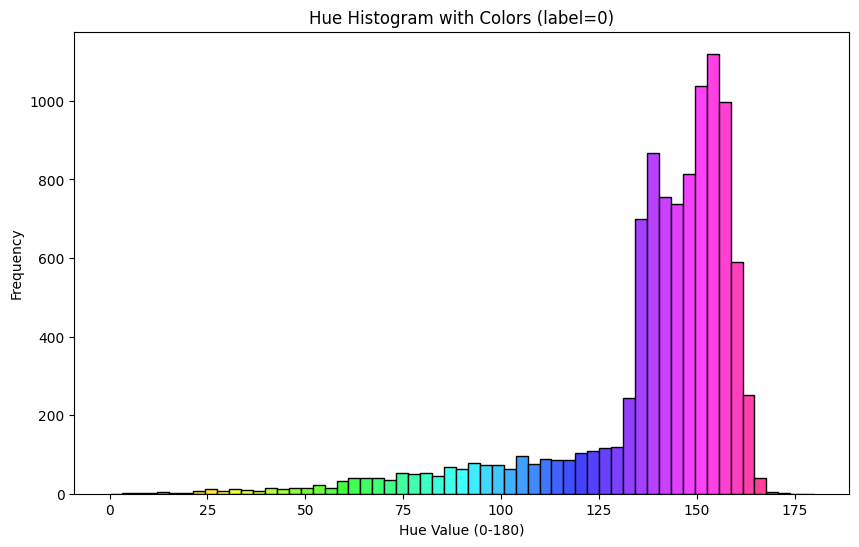

100%|██████████| 10000/10000 [00:15<00:00, 661.69it/s]


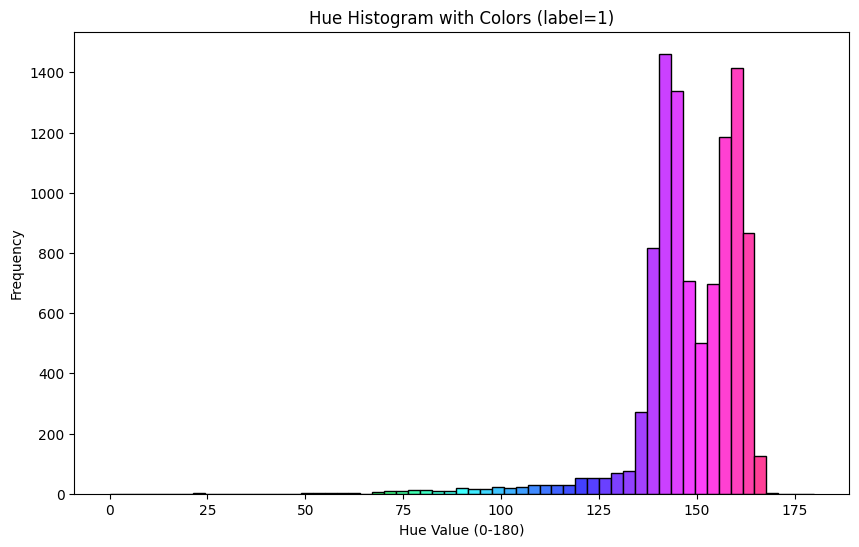

In [103]:
def plot_hue_histgram(ids, title):
    hue_values = []
    for id in tqdm(ids):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{id}.tif"
        img = cv2.imread(img_path)
        if img is not None:
            # convert to hsb color space
            hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
            # add hue channel mean of the image to array
            hue_channel = hsv_img[:, :, 0]
            hue_values.append(np.mean(hue_channel))
    
    
    # Plotting histgrams with hsb colored bar
    # Intuitive representation of which colors are included in large quantities 
    bins = np.linspace(0, 180, 60)
    hist, bin_edges = np.histogram(hue_values, bins=bins)
    colors = [mcolors.hsv_to_rgb((hue/180, 0.75, 1)) for hue in (bin_edges[:-1] + bin_edges[1:]) / 2]

    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(len(hist)):
        ax.bar(bin_edges[i], hist[i], width=bin_edges[i+1] - bin_edges[i],
               color=colors[i], edgecolor="black", align="edge")
    
    ax.set_xlabel("Hue Value (0-180)")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    plt.show()

plot_hue_histgram(sample_ids, "Hue Histogram with Colors")
plot_hue_histgram(sample_ids_0, "Hue Histogram with Colors (label=0)")
plot_hue_histgram(sample_ids_1, "Hue Histogram with Colors (label=1)")

The next plot is for saturation.

- label=0 means that there are many samples with small saturation.
- This indicates that there are more bright areas in the microscope image, which means that the density of stained tissue may be lower in the image.

100%|██████████| 10000/10000 [00:15<00:00, 662.28it/s]


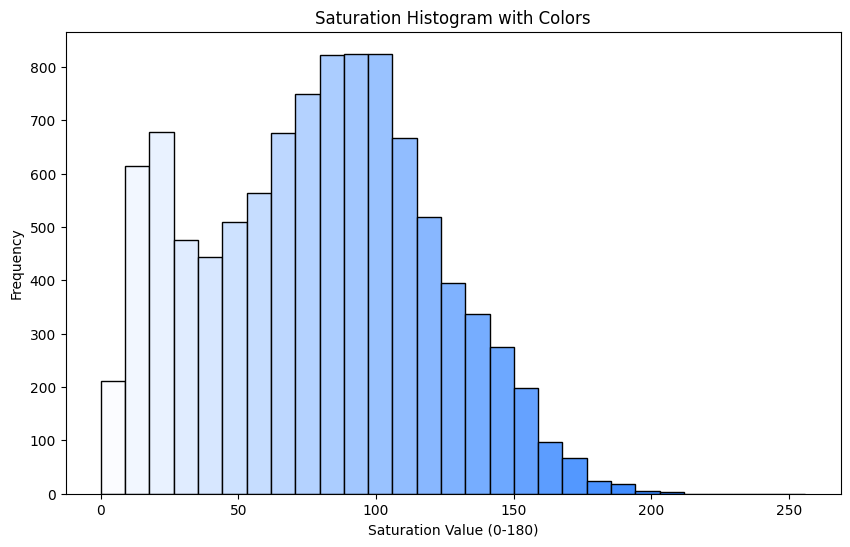

100%|██████████| 10000/10000 [00:14<00:00, 673.45it/s]


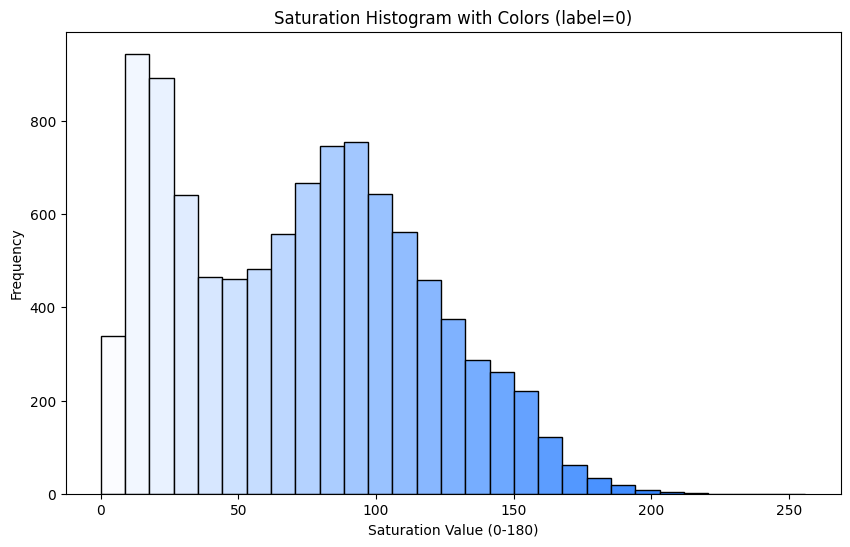

100%|██████████| 10000/10000 [00:14<00:00, 680.82it/s]


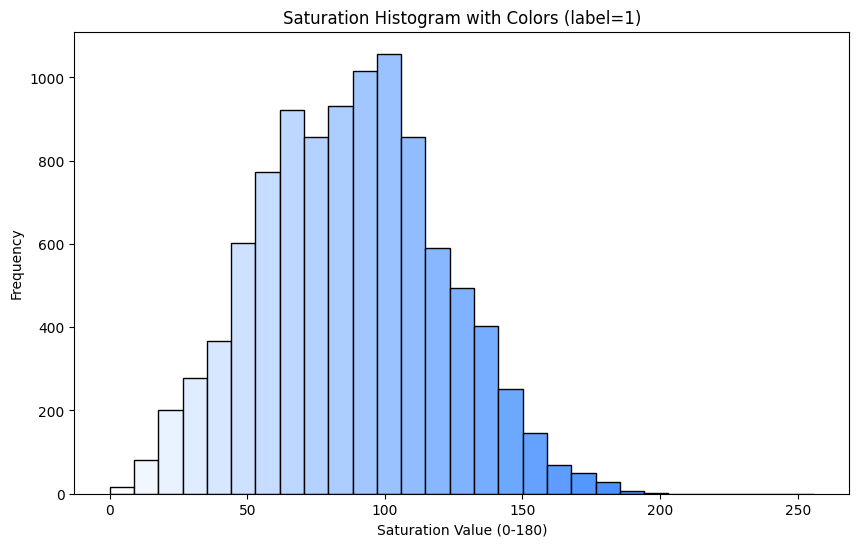

In [101]:
def plot_sat_histgram(ids, title):
    values = []
    for id in tqdm(ids):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{id}.tif"
        img = cv2.imread(img_path)
        if img is not None:
            # convert to hsb color space
            hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
            # add saturation channel mean of the image to array
            channel = hsv_img[:, :, 1]
            values.append(np.mean(channel))
    
    
    # Plotting histgrams with hsb colored bar
    # Intuitive representation of which colors are included in large quantities 
    bins = np.linspace(0, 256, 30)
    hist, bin_edges = np.histogram(values, bins=bins)
    colors = [mcolors.hsv_to_rgb((0.6, s / 255, 1)) for s in (bin_edges[:-1] + bin_edges[1:]) / 2]

    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(len(hist)):
        ax.bar(bin_edges[i], hist[i], width=bin_edges[i+1] - bin_edges[i],
               color=colors[i], edgecolor="black", align="edge")
    
    ax.set_xlabel("Saturation Value (0-180)")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    plt.show()

plot_sat_histgram(sample_ids, "Saturation Histogram with Colors")
plot_sat_histgram(sample_ids_0, "Saturation Histogram with Colors (label=0)")
plot_sat_histgram(sample_ids_1, "Saturation Histogram with Colors (label=1)")

Finally, let's look at the brightness plots.

The largest difference between label=0 and label=1 is in the frequency around 200-250, which is less for label=1. As with hue and sat, this may be due to the fact that label=1, where cancer is observed, tends to make the entire image darker due to the density and staining of the tissue.

100%|██████████| 10000/10000 [00:15<00:00, 665.07it/s]


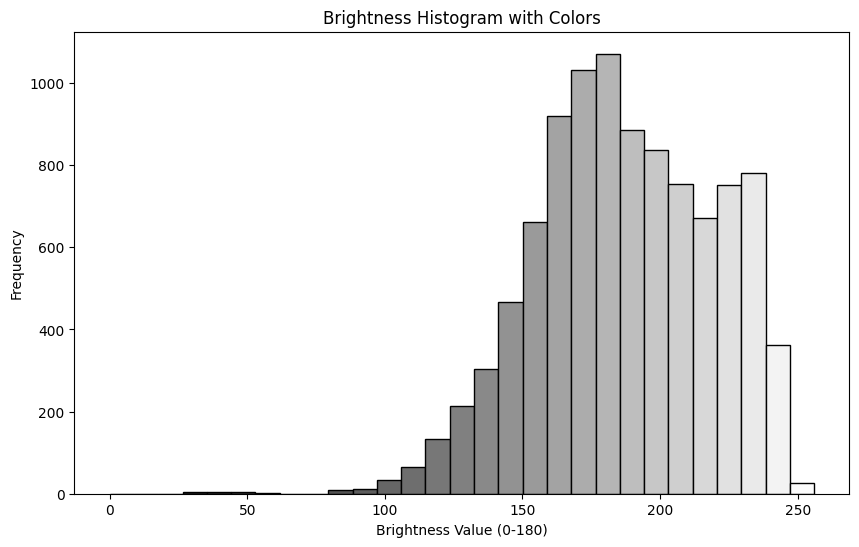

100%|██████████| 10000/10000 [00:15<00:00, 663.18it/s]


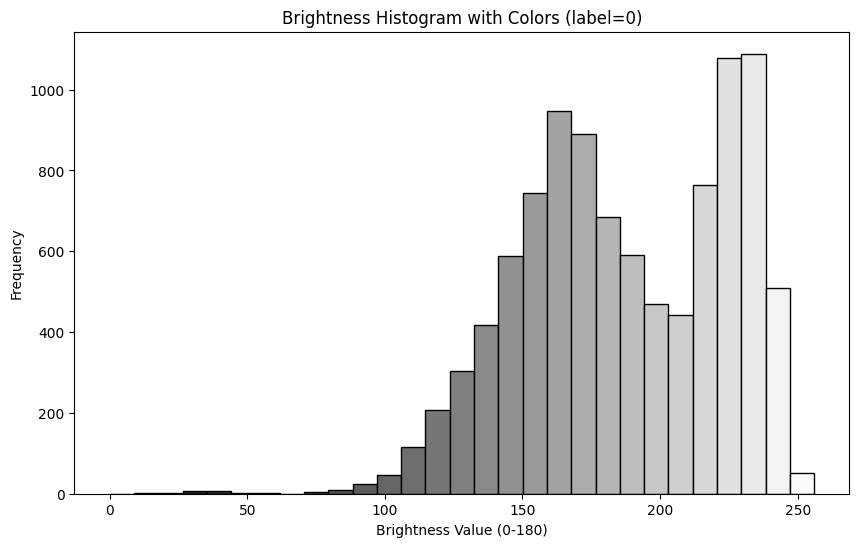

100%|██████████| 10000/10000 [00:14<00:00, 682.42it/s]


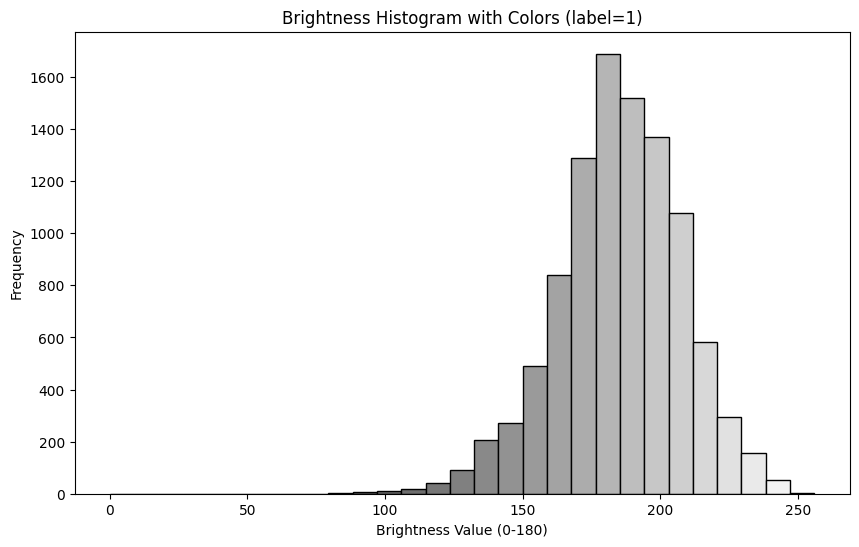

In [102]:
def plot_brightness_histgram(ids, title):
    values = []
    for id in tqdm(ids):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{id}.tif"
        img = cv2.imread(img_path)
        if img is not None:
            # convert to hsb color space
            hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
            # add brightness channel mean of the image to array
            channel = hsv_img[:, :, 2]
            values.append(np.mean(channel))
    
    
    # Plotting histgrams with hsb colored bar
    # Intuitive representation of which colors are included in large quantities 
    bins = np.linspace(0, 256, 30)
    hist, bin_edges = np.histogram(values, bins=bins)
    colors = [mcolors.hsv_to_rgb((0, 0, b / 255)) for b in (bin_edges[:-1] + bin_edges[1:]) / 2]

    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(len(hist)):
        ax.bar(bin_edges[i], hist[i], width=bin_edges[i+1] - bin_edges[i],
               color=colors[i], edgecolor="black", align="edge")
    
    ax.set_xlabel("Brightness Value (0-180)")
    ax.set_ylabel("Frequency")
    ax.set_title(title)
    plt.show()

plot_brightness_histgram(sample_ids, "Brightness Histogram with Colors")
plot_brightness_histgram(sample_ids_0, "Brightness Histogram with Colors (label=0)")
plot_brightness_histgram(sample_ids_1, "Brightness Histogram with Colors (label=1)")

# Image Data Preprocessing

* Pre-processing is to build a pipeline that can be passed directly to keras.
* Do standardization of the images since there are variations in brightness.

In [110]:
df['filename'] = df['id'].apply(lambda x: f"/kaggle/input/histopathologic-cancer-detection/train/{x}.tif")

# for iteration speed, make subset (30% of all data)
sub_x, _, sub_y, _ = train_test_split(
    df['filename'].values, df['label'].values, test_size=0.7, random_state=57, stratify=df['label'].values
)
train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    sub_x, sub_y, test_size=0.2, random_state=57
)

BATCH_SIZE = 128

def load_image(filename, label):
    img = tf.io.read_file(filename)
    img = tfio.experimental.image.decode_tiff(img)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    img = tf.image.per_image_standardization(img)
    img = img[:, :, :3] # drop "A" channel from RGBA
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
train_ds = train_ds.map(load_image).shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
val_ds = val_ds.map(load_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

for img, label in train_ds.take(1):
    print("Image shape:", img.shape)
    print("Label:", label)

Image shape: (128, 96, 96, 3)
Label: tf.Tensor(
[1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1
 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1
 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0], shape=(128,), dtype=int64)


# Model Architectures

* I will try two different models.
* Then do hyperparameter tuning and try to see how much it improves.

## Baseline model

A typical CNN for image classification tasks is the baseline model. After the convolution→pooling block appears three times, it has a structure that leads from fully connected to the output layer.

In [111]:
baseline_model = models.Sequential(name='1st_basic', layers=[
    keras.Input(shape=(96, 96, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # this is a workaround for a bug of Flatten()
    # ref: https://github.com/tensorflow/tensorflow/issues/64177
    layers.Reshape((12800,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[metrics.AUC(name='auc')]
)

baseline_model.summary()

Model: "1st_basic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_478 (Conv2D)             │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_392               │ (None, 47, 47, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_479 (Conv2D)             │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_393               │ (None, 22, 22, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_480 (Conv2D)             │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_394               │ (None, 10, 10, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_54 (Reshape)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
callback_es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
baseline_history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[callback_es],
)

Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 76s 167ms/step - auc: 0.7544 - loss: 0.6095 - val_auc: 0.9001 - val_loss: 0.3896
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - auc: 0.8956 - loss: 0.4002 - val_auc: 0.9248 - val_loss: 0.3427
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - auc: 0.9215 - loss: 0.3493 - val_auc: 0.9386 - val_loss: 0.3119
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - auc: 0.9377 - loss: 0.3116 - val_auc: 0.9490 - val_loss: 0.2859
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - auc: 0.9469 - loss: 0.2885 - val_auc: 0.9468 - val_loss: 0.3039
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - auc: 0.9603 - loss: 0.2503 - val_auc: 0.9588 - val_loss: 0.2615
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - auc: 0.9679 - loss: 0.2253 - val_auc: 0.9592 - val_loss: 0.2624
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - auc: 0.9753 - loss: 0.1989 - val_auc: 0.9568 - val_loss: 0.2795


In [17]:
baseline_model.save_weights('baseline_model.weights.h5', overwrite=True)
with open("baseline_history.pkl", "wb") as f:
    pickle.dump(baseline_history, f)

## RGB+HSV CNN model

* To test a model different from a typical CNN, we tried a pattern in which features in different color spaces are merged before being added to the fully connected layer.
* As we confirmed in the EDA, features were observed for each label in RGB and HSB, respectively.

The structure is as follows: transform the received images inside the network, perform convolution in each color space, and finally merge them before adding them to the fc layer.

In [113]:
def rgb_to_hsv(image):
    return tf.image.rgb_to_hsv(image)

rgb_input = keras.Input(shape=(96, 96, 3), name="rgb_input")
hsv_input = layers.Lambda(rgb_to_hsv, name="hsv_conversion")(rgb_input)

rgb_branch = layers.Conv2D(32, (5, 5), strides=(2,2), activation='relu', padding='same')(rgb_input)
rgb_branch = layers.MaxPooling2D((3, 3), strides=(2, 2))(rgb_branch)
rgb_branch = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(rgb_branch)
rgb_branch = layers.MaxPooling2D((2, 2))(rgb_branch)
rgb_branch = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(rgb_branch)
rgb_branch = layers.MaxPooling2D((2, 2))(rgb_branch)
rgb_branch = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(rgb_branch)
rgb_branch = layers.MaxPooling2D((2, 2))(rgb_branch)

hsv_branch = layers.Conv2D(32, (5, 5), strides=(2,2), activation='relu', padding='same')(hsv_input)
hsv_branch = layers.MaxPooling2D((3, 3), strides=(2, 2))(hsv_branch)
hsv_branch = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(hsv_branch)
hsv_branch = layers.MaxPooling2D((2, 2))(hsv_branch)
hsv_branch = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(hsv_branch)
hsv_branch = layers.MaxPooling2D((2, 2))(hsv_branch)
hsv_branch = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(hsv_branch)
hsv_branch = layers.MaxPooling2D((2, 2))(hsv_branch)

merged = layers.Concatenate()([rgb_branch, hsv_branch])
merged = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(merged)
merged = layers.BatchNormalization()(merged)
merged = layers.Reshape(target_shape=(2*2*64,))(merged)

fc = layers.Dense(128, activation='relu')(merged)
fc = layers.Dropout(0.5)(fc)
output = layers.Dense(1, activation='sigmoid')(fc)

model_color_space = models.Model(inputs=rgb_input, outputs=output, name="parallel_color_space")
model_color_space.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[metrics.AUC(name='auc')]
)

model_color_space.summary()

Model: "parallel_color_space"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hsv_conversion      │ (None, 96, 96, 3) │          0 │ rgb_input[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_481 (Conv2D) │ (None, 48, 48,    │      2,432 │ rgb_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_485 (Conv2D) │ (None, 48, 48,    │      2,432 │ hsv_conversion[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_395   │ (None, 23, 23,    │          0 │ conv2d_481[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_399   │ (None, 23, 23,    │          0 │ conv2d_485[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_482 (Conv2D) │ (None, 23, 23,    │      9,248 │ max_pooling2d_39… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_486 (Conv2D) │ (None, 23, 23,    │      9,248 │ max_pooling2d_39… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_396   │ (None, 11, 11,    │          0 │ conv2d_482[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_400   │ (None, 11, 11,    │          0 │ conv2d_486[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_483 (Conv2D) │ (None, 11, 11,    │     18,496 │ max_pooling2d_39… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_487 (Conv2D) │ (None, 11, 11,    │     18,496 │ max_pooling2d_40… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_397   │ (None, 5, 5, 64)  │          0 │ conv2d_483[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_401   │ (None, 5, 5, 64)  │          0 │ conv2d_487[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_484 (Conv2D) │ (None, 5, 5, 128) │     73,856 │ max_pooling2d_39… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_488 (Conv2D) │ (None, 5, 5, 128) │     73,856 │ max_pooling2d_40… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_398   │ (None, 2, 2, 128) │          0 │ conv2d_484[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 257,793 (1007.00 KB)

 Trainable params: 257,665 (1006.50 KB)

 Non-trainable params: 128 (512.00 B)

In [114]:
callback_es2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
color_history = model_color_space.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[callback_es2],
)

Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - auc: 0.7187 - loss: 0.6264 - val_auc: 0.8603 - val_loss: 0.8477
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - auc: 0.8768 - loss: 0.4328 - val_auc: 0.8939 - val_loss: 0.6395
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - auc: 0.9056 - loss: 0.3812 - val_auc: 0.9228 - val_loss: 0.4078
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 39s 94ms/step - auc: 0.9179 - loss: 0.3565 - val_auc: 0.9256 - val_loss: 0.4673
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 39s 94ms/step - auc: 0.9290 - loss: 0.3325 - val_auc: 0.9307 - val_loss: 0.6640
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - auc: 0.9352 - loss: 0.3183 - val_auc: 0.9194 - val_loss: 0.7282
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - auc: 0.9392 - loss: 0.3079 - val_auc: 0.9305 - val_loss: 0.7011


In [7]:
model_color_space.save_weights('model_color_space.weights.h5', overwrite=True)
with open("color_history.pkl", "wb") as f:
    pickle.dump(color_history, f)

### Model Comparison

I will compare trained model performance and decide which to tune.

The following graphs show the train/validation learning curves for the two models.

* Convergence is smooth for the baseline model.
* The color space model has a large upward and downward movement in validation loss.

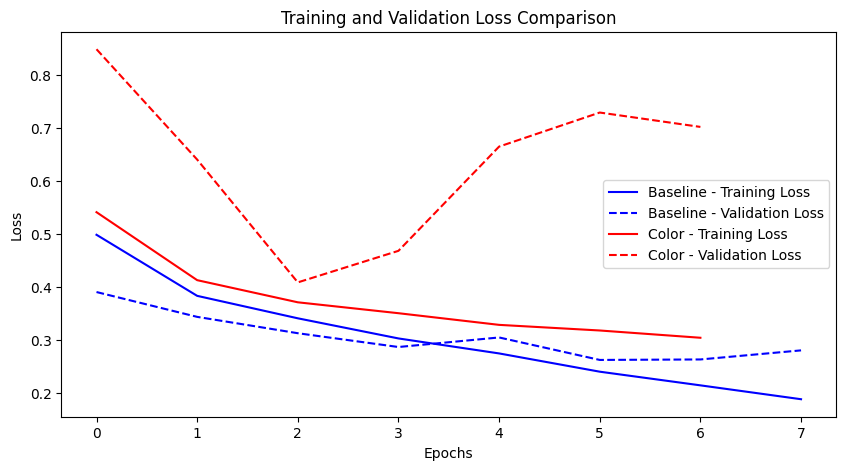

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(baseline_history.history['loss'], 'b-', label='Baseline - Training Loss')
plt.plot(baseline_history.history['val_loss'], 'b--', label='Baseline - Validation Loss')
plt.plot(color_history.history['loss'], 'r-', label='Color - Training Loss')
plt.plot(color_history.history['val_loss'], 'r--', label='Color - Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()

Next, predict is performed on the fitted model to draw ROC Curve.

In [117]:
from sklearn.metrics import confusion_matrix, recall_score, roc_curve, auc, ConfusionMatrixDisplay

def load_image_for_predict(filename):
    img = tf.io.read_file(filename)
    img = tfio.experimental.image.decode_tiff(img)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    # img = img / 255.0
    img = tf.image.per_image_standardization(img)
    img = img[:, :, :3] # drop "A" channel from RGBA
    return img

val_ds_for_predict = tf.data.Dataset.from_tensor_slices(val_filenames)
val_ds_for_predict = val_ds_for_predict.map(load_image_for_predict).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [118]:
y_true = val_labels
y_pred_baseline = baseline_model.predict(val_ds_for_predict)
y_pred_color_space = model_color_space.predict(val_ds_for_predict)

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step


Drawing the ROC Curve, we can see that the scores given by the two models are almost the same, even though the baseline model has 1.7M parameters, while the color space model has only about 26k parameters.

In other words, it is safe to say that the model using HSV-converted images as features performs better for a smaller number of parameters.

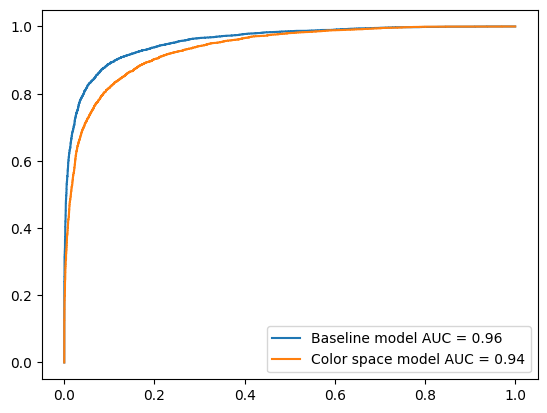

In [119]:
fpr1, tpr1, _ = roc_curve(y_true, y_pred_baseline)
fpr2, tpr2, _ = roc_curve(y_true, y_pred_color_space)
plt.plot(fpr1, tpr1, label=f'Baseline model AUC = {auc(fpr1, tpr1):.2f}')
plt.plot(fpr2, tpr2, label=f'Color space model AUC = {auc(fpr2, tpr2):.2f}')
plt.legend()
plt.show()

The Confusion Matrix shows the following.

* The second plot shows that the color space model has less False Positives and more False Negatives than the baseline model.
* In the medical task of cancer detection, a high FN rate can lead to missing a serious disease, which is an issue that needs to be improved.

Text(0.5, 1.0, 'Color space model')

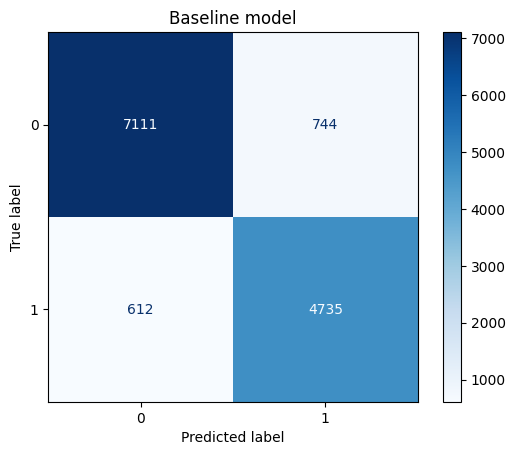

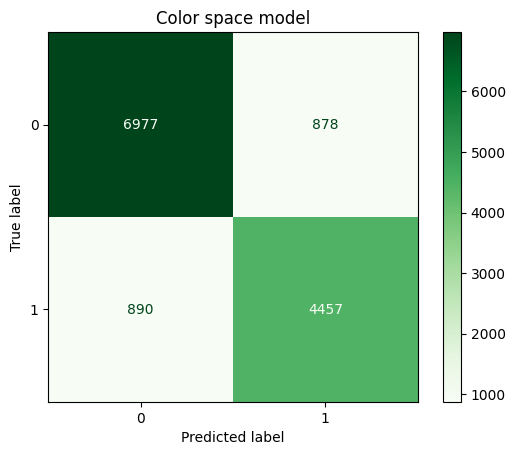

In [120]:
fpr1, tpr1, thresholds1 = roc_curve(y_true, y_pred_baseline)
fpr2, tpr2, thresholds2  = roc_curve(y_true, y_pred_color_space)

# Youden's J statistic
optimal_idx1 = np.argmax(tpr1 - fpr1)
optimal_threshold1 = thresholds1[optimal_idx1]

optimal_idx2 = np.argmax(tpr2 - fpr2)
optimal_threshold2 = thresholds2[optimal_idx2]

y_pred_baseline_label = (y_pred_baseline >= optimal_threshold1).astype(int)
y_pred_color_space_label = (y_pred_color_space >= optimal_threshold2).astype(int)

cm1 = confusion_matrix(y_true, y_pred_baseline_label)
cm2 = confusion_matrix(y_true, y_pred_color_space_label)

cmplot1 = ConfusionMatrixDisplay(cm1, display_labels=[0, 1])
cmplot1.plot(cmap='Blues')
cmplot1.ax_.set_title("Baseline model")
cmplot2 = ConfusionMatrixDisplay(cm2, display_labels=[0, 1])
cmplot2.plot(cmap='Greens')
cmplot2.ax_.set_title("Color space model")

### Summary
* There is almost no difference in the final percentage of correct responses between the two models.
* Convergence of the models was smoother for the baseline model, while the validation score moved up and down for the color space model.

In the following sections, I will attempt to improve the performance of the color space model, which has shown interesting performance with small parameter sizes.

## Hyperparameter Tuning

Tuning the color space model.
* Introduce class weight.
* Exploring learning rates.

In [49]:
def build_color_space_cnn(name="tuned_color_space"):
    rgb_input = keras.Input(shape=(96, 96, 3), name="rgb_input")
    hsv_input = layers.Lambda(rgb_to_hsv, name="hsv_conversion")(rgb_input)
    
    rgb_branch = layers.Conv2D(32, (5, 5), strides=(2,2), activation='relu', padding='same')(rgb_input)
    rgb_branch = layers.MaxPooling2D((3, 3), strides=(2, 2))(rgb_branch)
    rgb_branch = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(rgb_branch)
    rgb_branch = layers.MaxPooling2D((2, 2))(rgb_branch)
    rgb_branch = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(rgb_branch)
    rgb_branch = layers.MaxPooling2D((2, 2))(rgb_branch)
    rgb_branch = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(rgb_branch)
    rgb_branch = layers.MaxPooling2D((2, 2))(rgb_branch)
    
    hsv_branch = layers.Conv2D(32, (5, 5), strides=(2,2), activation='relu', padding='same')(hsv_input)
    hsv_branch = layers.MaxPooling2D((3, 3), strides=(2, 2))(hsv_branch)
    hsv_branch = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(hsv_branch)
    hsv_branch = layers.MaxPooling2D((2, 2))(hsv_branch)
    hsv_branch = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(hsv_branch)
    hsv_branch = layers.MaxPooling2D((2, 2))(hsv_branch)
    hsv_branch = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(hsv_branch)
    hsv_branch = layers.MaxPooling2D((2, 2))(hsv_branch)
    
    merged = layers.Concatenate()([rgb_branch, hsv_branch])
    merged = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(merged)
    merged = layers.BatchNormalization()(merged)
    merged = layers.Reshape(target_shape=(2*2*64,))(merged)
    
    fc = layers.Dense(128, activation='relu')(merged)
    fc = layers.Dropout(0.5)(fc)
    output = layers.Dense(1, activation='sigmoid')(fc)
    
    model = models.Model(inputs=rgb_input, outputs=output, name=name)

    return model

def build_model_to_tune_lr(lr):
    model = build_color_space_cnn()
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[metrics.AUC(name='auc')]
    )

    return model

In [76]:
from sklearn.utils import class_weight

cw_ = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
cw = {
    0: cw[0],
    1: cw[1],
}

In [77]:
search_history = {}
for lr in [1e-4, 3e-4, 1e-5, 5e-5]:
    search_model = build_model_to_tune_lr(lr)
    
    h = search_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        class_weight=cw,
        verbose=1,
    )

    search_history[lr] = h

Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - auc: 0.6378 - loss: 0.6973 - val_auc: 0.7532 - val_loss: 0.6296
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - auc: 0.7862 - loss: 0.5679 - val_auc: 0.8393 - val_loss: 0.5733
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - auc: 0.8445 - loss: 0.4924 - val_auc: 0.8533 - val_loss: 0.5127
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - auc: 0.8686 - loss: 0.4563 - val_auc: 0.8769 - val_loss: 0.4625
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - auc: 0.8833 - loss: 0.4302 - val_auc: 0.8922 - val_loss: 0.4828
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - auc: 0.8970 - loss: 0.4067 - val_auc: 0.8970 - val_loss: 0.4177
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - auc: 0.9045 - loss: 0.3920 - val_auc: 0.9100 - val_loss: 0.3928
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - auc: 0.9127 - loss: 0.3763 - val_auc: 0.9138 - val_loss: 0.4052
Epoch 9/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 

Let's plot the evolution of validation loss for each learning rate.

* 1e-5 and 5e-5 converge too slowly.
* 1e-4 is too unstable and converges too slowly.
* 3e-4 converges too fast and is less volatile, so it may be close to optimal.

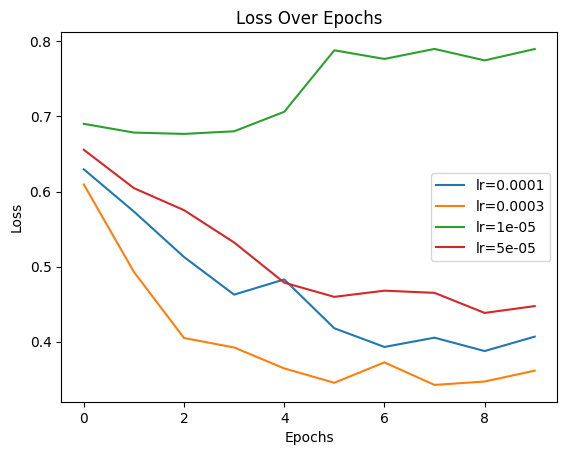

In [78]:
for lr, h in search_history.items():
    plt.plot(h.history['val_loss'], label=f'lr={lr}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

先ほど使った learning rate を使ってモデルを訓練する

In [105]:
from sklearn.model_selection import KFold

# first, keep 20% of whole data for test set
x_train, x_test, y_train, y_test = train_test_split(
    df['filename'].values, df['label'].values, test_size=0.2, random_state=42, stratify=df['label'].values
)

# then, use the rest of dataset for 3-Fold CV
kf = KFold(n_splits=3, shuffle=True, random_state=2377)

fold_models = []
fold_hists = []
val_losses = []
for train_index, val_index in kf.split(x_train):
    i = 0
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    train_ds_fold = tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
    train_ds_fold = train_ds_fold.map(load_image).shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    val_ds_fold = tf.data.Dataset.from_tensor_slices((x_val_fold, y_val_fold))
    val_ds_fold = val_ds_fold.map(load_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    model = build_color_space_cnn()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        loss="binary_crossentropy",
        metrics=["AUC"],
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"cv_model_{i}.weights.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        verbose=1
    )

    cw_ = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    cw = {
        0: cw[0],
        1: cw[1],
    }

    h = model.fit(
        train_ds_fold,
        validation_data=val_ds_fold,
        epochs=10,
        class_weight=cw,
        verbose=1,
        callbacks=[lr_scheduler, model_checkpoint],
    )

    fold_models.append(model)
    fold_hists.append(h)
    val_losses.append(min(h.history["val_loss"]))
    i += 1

Epoch 1/10
917/917 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - AUC: 0.7522 - loss: 0.5957
Epoch 1: val_loss improved from inf to 0.51230, saving model to cv_model_0.weights.h5
917/917 ━━━━━━━━━━━━━━━━━━━━ 107s 109ms/step - AUC: 0.7523 - loss: 0.5956 - val_AUC: 0.8816 - val_loss: 0.5123 - learning_rate: 3.0000e-04
Epoch 2/10
916/917 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - AUC: 0.8977 - loss: 0.4052
Epoch 2: val_loss improved from 0.51230 to 0.38074, saving model to cv_model_0.weights.h5
917/917 ━━━━━━━━━━━━━━━━━━━━ 65s 70ms/step - AUC: 0.8977 - loss: 0.4052 - val_AUC: 0.9213 - val_loss: 0.3807 - learning_rate: 3.0000e-04
Epoch 3/10
915/917 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - AUC: 0.9179 - loss: 0.3648
Epoch 3: val_loss did not improve from 0.38074
917/917 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - AUC: 0.9179 - loss: 0.3648 - val_AUC: 0.9221 - val_loss: 0.4342 - learning_rate: 3.0000e-04
Epoch 4/10
915/917 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - AUC: 0.9270 - loss: 0.3453
Epoch 4: val_loss improved from 0.38

In [60]:
tuned_model.save_weights('tuned_model.weights.h5', overwrite=True)
with open("tuned_history.pkl", "wb") as f:
    pickle.dump(tuned_history, f)

# Results and Analysis

Using the explored learning rate, the final score was raised slightly.
However, this was not a significant improvement, and the reason for this may be that the model tuned in this study makes extensive use of stride and global pooling to reduce the number of parameters, which may have limited its expressive power.

In [106]:
y_true = y_test
val_ds_for_predict = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_ds_for_predict = val_ds_for_predict.map(load_image).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

y_preds_tuned = []
for fm in fold_models:
    y_preds_tuned.append(fm.predict(val_ds_for_predict))
y_pred_tuned = np.mean(y_preds_tuned, axis=0)

344/344 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step


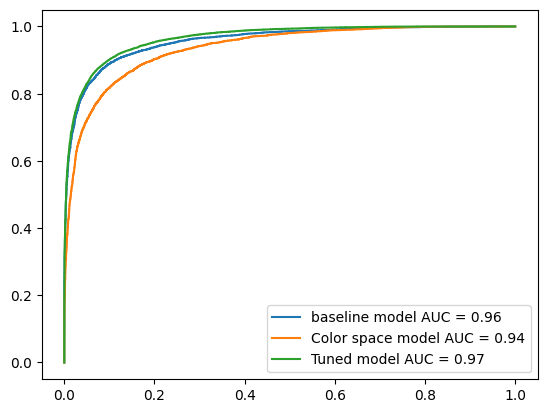

In [123]:
y_true = y_test
fpr3, tpr3, _ = roc_curve(y_true, y_pred_tuned)
plt.plot(fpr1, tpr1, label=f'baseline model AUC = {auc(fpr1, tpr1):.2f}')
plt.plot(fpr2, tpr2, label=f'Color space model AUC = {auc(fpr2, tpr2):.2f}')
plt.plot(fpr3, tpr3, label=f'Tuned model AUC = {auc(fpr3, tpr3):.2f}')
plt.legend()
plt.show()

confusion matrix がここに必要

Text(0.5, 1.0, 'Tuned model')

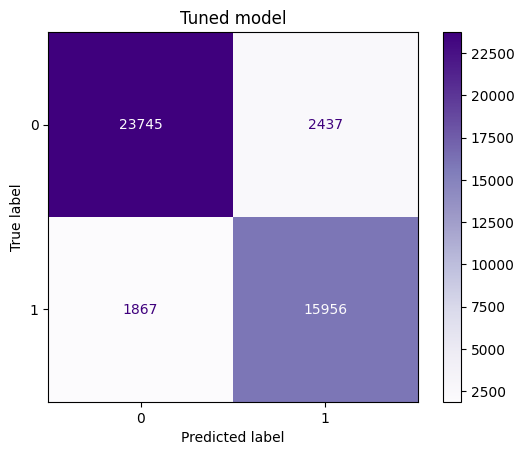

In [124]:
fpr3, tpr3, thresholds = roc_curve(y_true, y_pred_tuned)
optimal_idx = np.argmax(tpr3 - fpr3)
optimal_threshold = thresholds[optimal_idx]

y_pred_tuned_label = (y_pred_tuned >= optimal_threshold).astype(int)

# compute confusion matrix for tuned model
cm3 = confusion_matrix(y_true, y_pred_tuned_label)

cmplot3 = ConfusionMatrixDisplay(cm3, display_labels=[0, 1])
cmplot3.plot(cmap='Purples')
cmplot3.ax_.set_title("Tuned model")

# Conclusion.

* I worked on the task of detecting cancer based on microscopic images and trained and evaluated EDA, image preprocessing, and models.
* In EDA, we found that the distribution of values for each label is different in HSV space, so I compared two types of models using features in RGB and HSV color space, in addition to a typical CNN.
* Compared to the CNN, the color space model showed high generalization performance, roc auc = 0.94, even though it is a lightweight model with only 1/6th the number of parameters.
* Optimization results, such as hyperparameter tuning, resulted in ROC AUC = 0.97 after improvement.

The lightweight nature of such a model may have applications in resource-constrained environments such as small clinics and rural clinics.
* No access to cloud environment, or want to operate at low cost.
* Need to run on a local machine (CPU only).
* Cannot send data to the cloud due to data privacy and security issues.

## Submission

In [125]:
# define dataset for test data

test_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
test_df['filename'] = test_df['id'].apply(lambda x: f"/kaggle/input/histopathologic-cancer-detection/test/{x}.tif")

# load images without labels
def load_image_for_test(filename):
    img = tf.io.read_file(filename)
    img = tfio.experimental.image.decode_tiff(img)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    # img = img / 255.0
    img = tf.image.per_image_standardization(img)
    img = img[:, :, :3] # drop "A" channel from RGBA
    return img

test_ds = tf.data.Dataset.from_tensor_slices(test_df['filename'])
test_ds = test_ds.map(load_image_for_test).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [126]:
y_preds_final = []
for fm in fold_models:
    y_preds_final.append(fm.predict(test_ds))
test_df['label'] = np.mean(y_preds_final, axis=0)

449/449 ━━━━━━━━━━━━━━━━━━━━ 199s 442ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step


In [127]:
test_df.drop(columns=['filename'], inplace=True)
test_df.to_csv('submission.csv', index=False)

### Submission Result

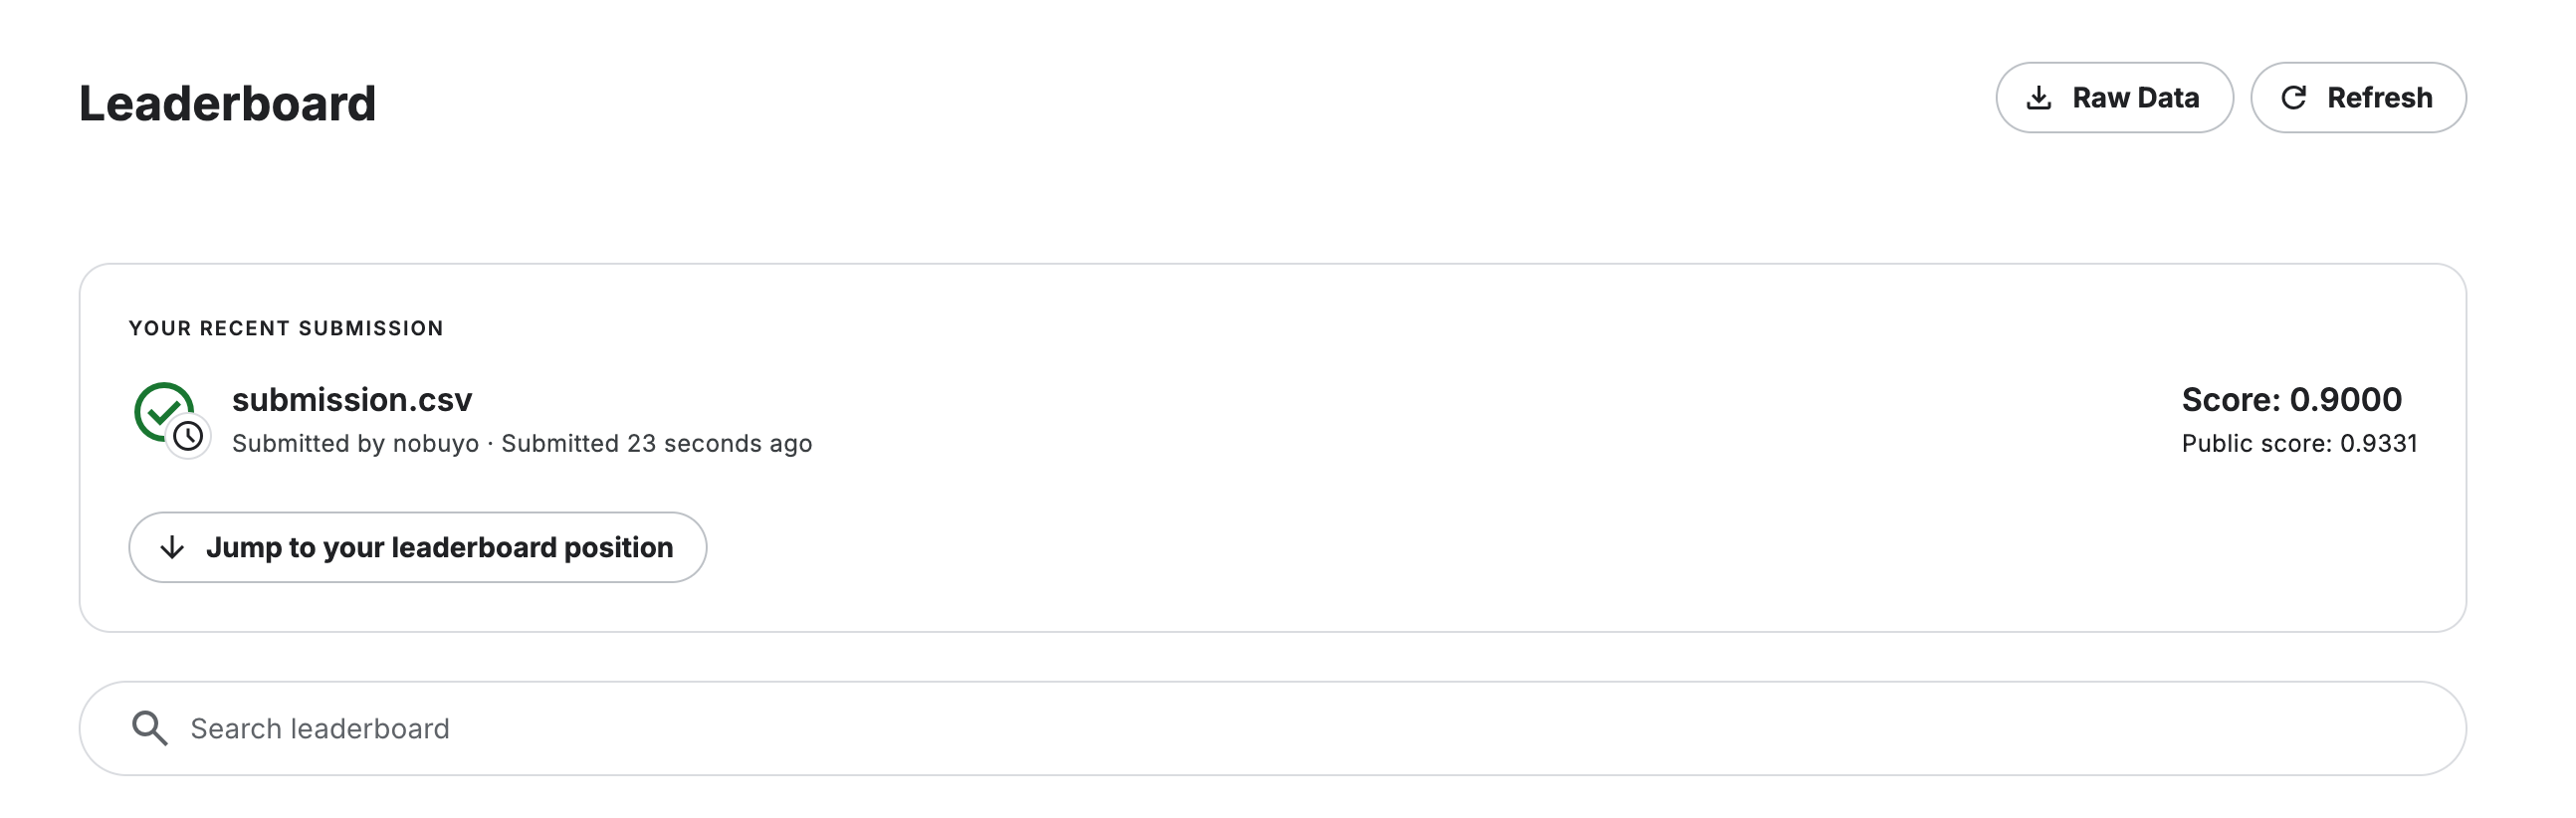
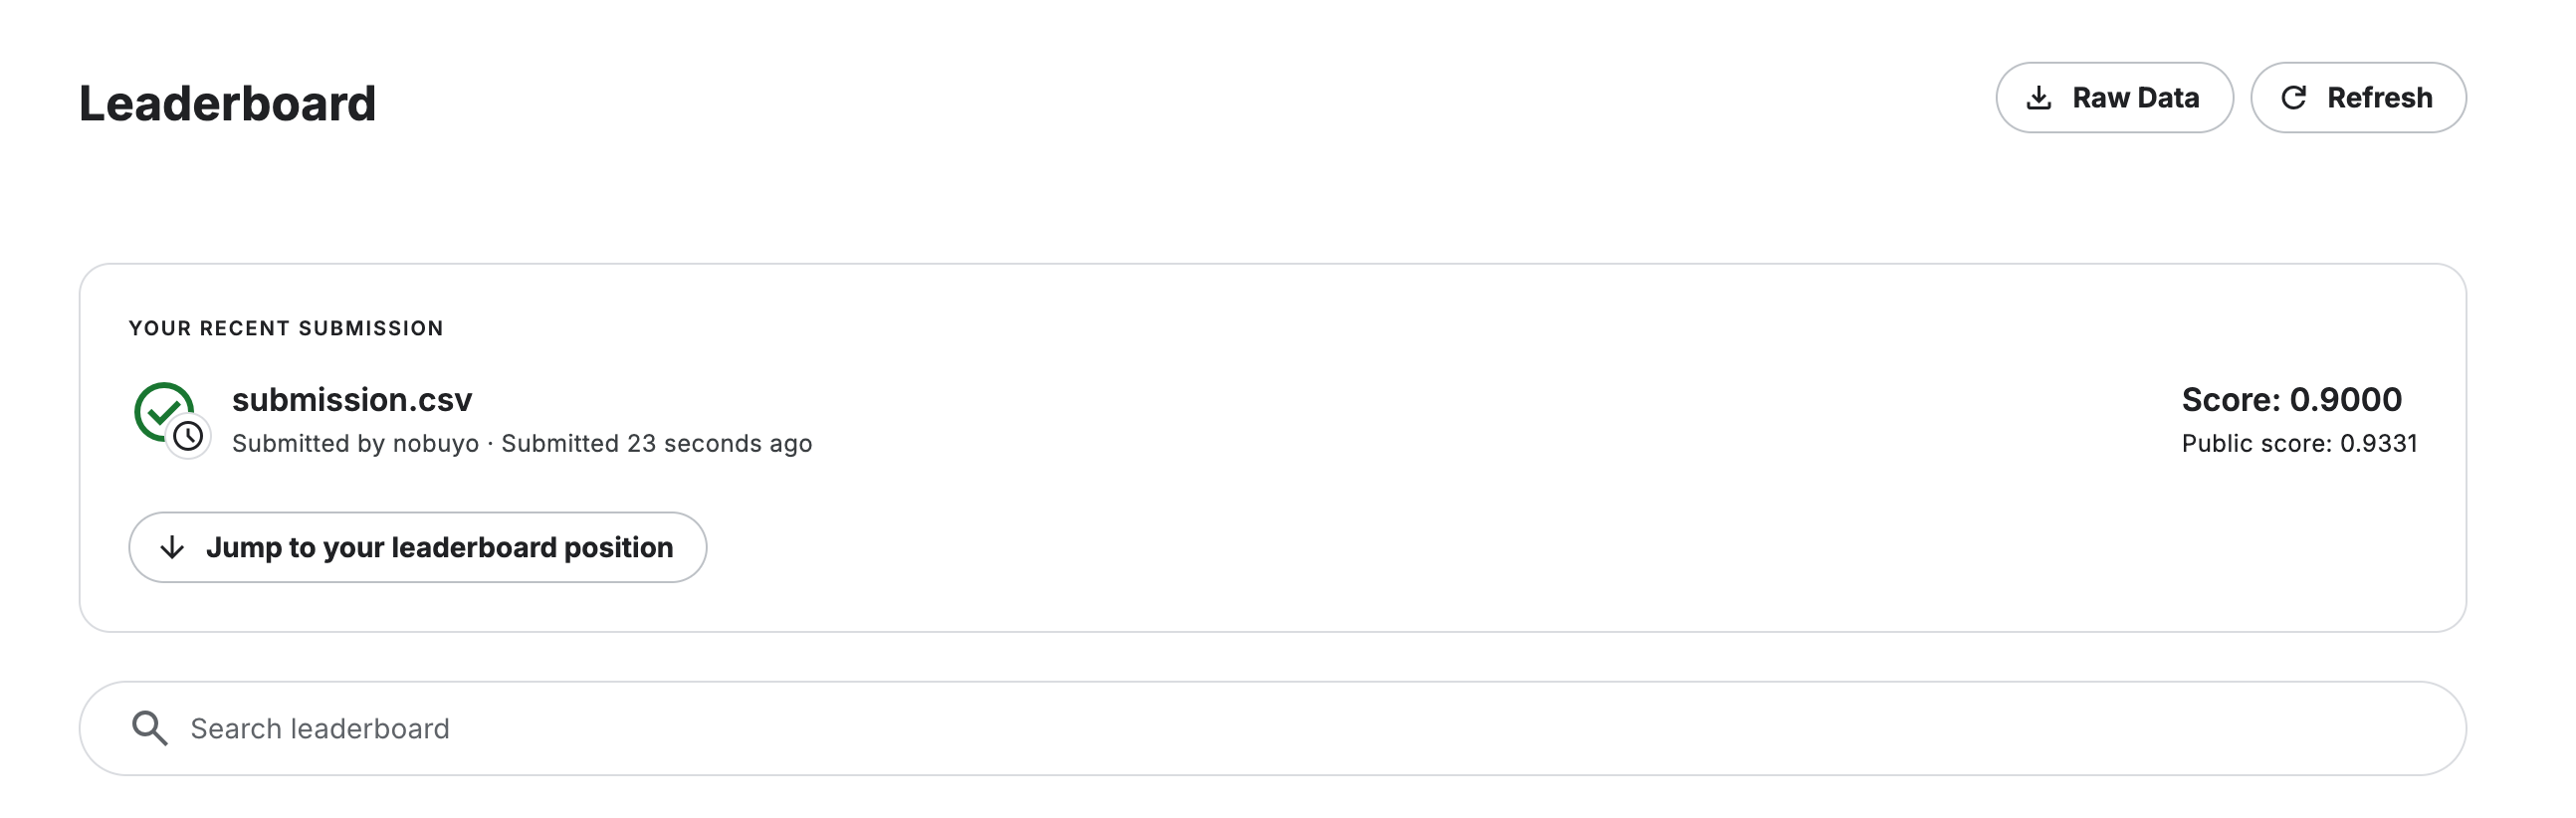